In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
import re #regex
import networkx as nx
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from utils.tools import replace_all, extract_course_catalog 

In [2]:
names, descriptions = extract_course_catalog('MATH')

In [7]:
df = pd.DataFrame(columns=['Course Name', 'Course Description', 'Course Units'])
courses = {}
department = {"WARR","WCWP","VIS","UROL","USP","UNAF","TDAC","TDDE","TDDM","TDDR","TDGE",
              "TDGR","TDHD","TDHT","TDMV","TDPF","TDPR","TDPW","TDTR","TMC","TWS","SE","SIO",
              "SIOB","SIOC","SIOG","SOCE","SOCG","SOCI","SOMC","SOMI","SPPS","SURG","RAD","RELI",
              "REV","RMAS","RMED","PATH","PEDS","PHAR","PHIL","PHYS","POLI","PSY","PSYC","OPTH",
              "ORTH","NANO","NEWU","NEUG","MAE","MATH","MATS","MBC","MCWP","MED","MGT","MGTA","MGTF",
              "MGTP","MMW","MSED","MUIR","MUS","LTWR","LTWL","LTTH","LTSP","LTRU","LTLA","LTKO","LTIT",
              "LTGM","LTGK","LTFR","LTEU","LTEN","LTEA","LTCS","WES","AESE","AIP", "ANAR", "ANBI", "ANES", 
              "ANSC", "ANTH", "AUD", "AWP", "BENG", "BGGN","BGRD","BGSE", "BIBC", "BICD", "BIEB","BILD","BIMM", 
              "BIOM","BIPN","BISP","BNFO","CAT","CCS","CENG","CGS","CHEM","CHIN","CLIN","CLRE","CMM","COGR","COGS",
              "COMM","CSE","CSS", "DDPM","DERM","DOC","DSC","DSE","DSGN","ECE","ECON","EDS","EMED",
              "ENG","ENVR","ERC","ESYS","ETHN","ETIM","EXPR","FILM","FMPH","FPM","GLBH","GPCO","GPEC",
              "GPGN","GPIM","GPLA","GPPA","GPPS","HDS","HIAF","HIEA","HIEU","HIGR","HILA","HILD","HINE",
              "HISC","HITO","HIUS","HMNR","HUM","INTL","JAPN","JWSP","LATI","LHCO","LIAB","LIDS","LIFR",
              "LIGM","LIGN","LIHL","LIIT","LIPO","LISL","LISP","LTAM","LTCO"}

for course, description in zip(names, descriptions):
    course, description = course.getText(), description.getText()
    
    # Course ID check to filter upper div. classes.
    course_id = course[course.index(' ')+1:course.index('.')]
    while course_id[-1].isalpha() or course_id[-1] == '-':
        course_id = course_id[:-1]
    course_id = int(course_id)
    if course_id >= 200:
        continue
    
    # Grabs course info.
    course_name = course[:course.index('.')]
    prereqs = description.split("Prerequisites:",1)[1]
    for i, char in enumerate(prereqs):
        if char == "." or char ==";":
            prereqs = prereqs[:i]
    
    #prereqs_and = prereqs.split(" and ")
    prereqs_list = prereqs.split(" ")
    cleaned =[]
    encounter =False
    #[[class1,class2],[class3,class4]] reads as "class 1 or class 2 and class 3 or class 4"
    for i, word in enumerate(prereqs_list):
        #print(word)
#         word = word.replace(',','')
#         word = word.replace('higher','')
#         word = word.replace('better','')
#         word = word.replace(' with a grade of C–','')
#         prereqs_list.append(word.split(" or "))
        #print(word)
        if word in department:
            cleaned.append(word + " "+ replace_all([',',')','\n','\t'], prereqs_list[i+1]))
            encounter = True
        elif word == "or" and encounter:
            cleaned.append('or')
            encounter = False
        elif word == "and":
            cleaned.append('and')
    
    if len(cleaned) >0 and cleaned[-1] == 'or':
        cleaned.pop()
        
    courses[course_name] = cleaned
    course_title = course[course.index('.')+1:course.index('(')-1]
    course_units = course[course.index('('):course.index(')')+1]
    # Append row to data frame.
    df = df.append({
        'Course Name': course_name,
        'Course Description': description,
        'Course Units': course_units,
        'Prereqs': cleaned
    }, ignore_index=True)

In [8]:
courses

{'MATH 2': [],
 'MATH 3C': [],
 'MATH 4C': ['MATH 3C'],
 'MATH 10A': ['MATH 3C', 'or', 'MATH 4C'],
 'MATH 10B': ['MATH 10A', 'or', 'MATH 20A'],
 'MATH 10C': ['MATH 10B', 'or', 'MATH 20B'],
 'MATH 11': ['MATH 10B', 'or', 'MATH 20B'],
 'MATH 15A': ['CSE 8B', 'or', 'CSE 11'],
 'MATH 18': ['MATH 3C', 'or', 'MATH 4C', 'or', 'MATH 10A', 'or', 'MATH 20A'],
 'MATH 20A': ['MATH 2C', 'or', 'MATH 4C', 'or', 'MATH 10A'],
 'MATH 20B': ['MATH 20A', 'or', 'MATH 10B', 'or', 'MATH 10C'],
 'MATH 20C': ['MATH 20B'],
 'MATH 20D': ['MATH 20C', 'MATH 21C', 'or', 'MATH 31BH'],
 'MATH 20E': ['MATH 18',
  'or',
  'MATH 20F',
  'or',
  'MATH 31AH',
  'and',
  'MATH 20C',
  'MATH 21C',
  'or',
  'MATH 31BH'],
 'MATH 31AH': [],
 'MATH 31BH': ['MATH 31AH'],
 'MATH 31CH': ['MATH 31BH'],
 'MATH 87': [],
 'MATH 95': [],
 'MATH 96': ['MATH 20A'],
 'MATH 99R': ['and'],
 'MATH 100A': ['MATH 31CH', 'or', 'MATH 109'],
 'MATH 100B': ['MATH 100A'],
 'MATH 100C': ['MATH 100B'],
 'MATH 102': ['MATH 18',
  'or',
  'MATH 20F',


In [22]:
def group_nodes(nodes):
    

SyntaxError: unexpected EOF while parsing (<ipython-input-22-834986c263dc>, line 2)

In [13]:
def create_graph(edges):
    G = nx.DiGraph()
    G.add_edges_from(edges)
    colors = []
    for node in G.nodes():
        if node == test1:
            colors.append("Green")
        else:
            colors.append("Grey")
    plt.figure(3,figsize=(12,12))
    nx.draw_planar(G, with_labels=True, node_color = colors, width = 3, node_size = 1500)
    plt.show()

What class: MATH 103B


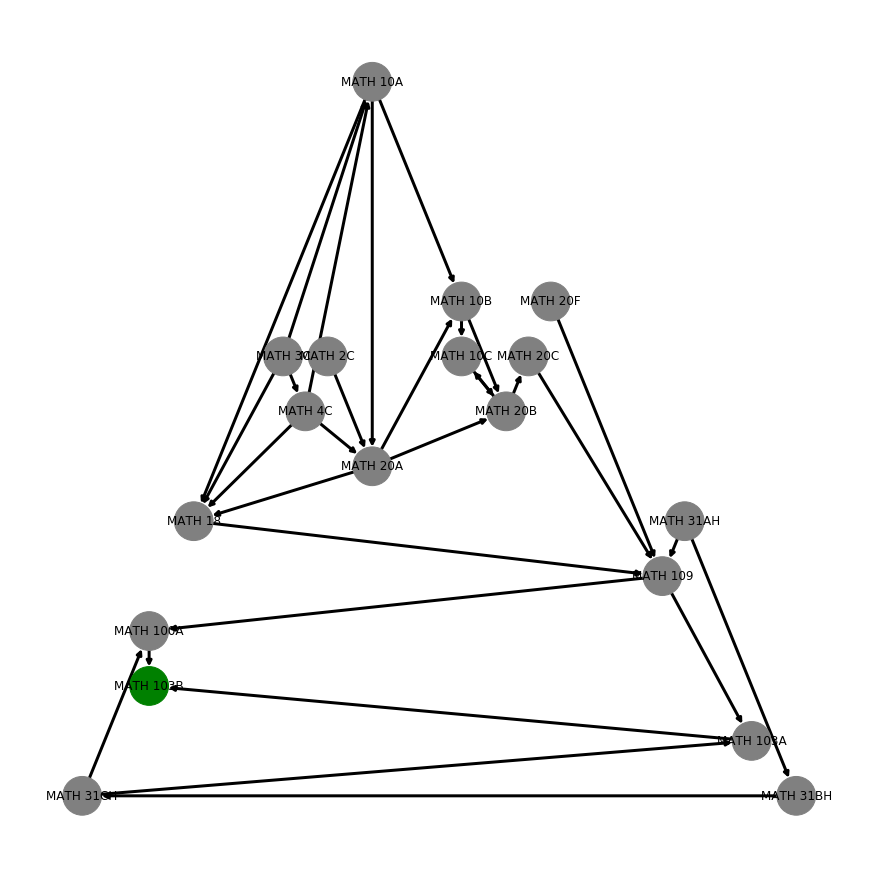

In [14]:
def runner(parse_course, edge_list, created):
    created.append(parse_course)
    if parse_course in courses:
        for course in courses[parse_course]:
            if course != 'or' and course != 'and':
                edge_list.append((course,parse_course))
                if course not in created:
                    runner(course, edge_list, created) 
            
already_created = []
edges = []
test1 = input("What class: ")
runner(test1, edges, already_created)
create_graph(edges)

/Users/brianbarry/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning:


The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.

/Users/brianbarry/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning:


The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.

/Users/brianbarry/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning:

Glyph 9 missing from current font.

/Users/brianbarry/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning:

Glyph 9 missing from current font.



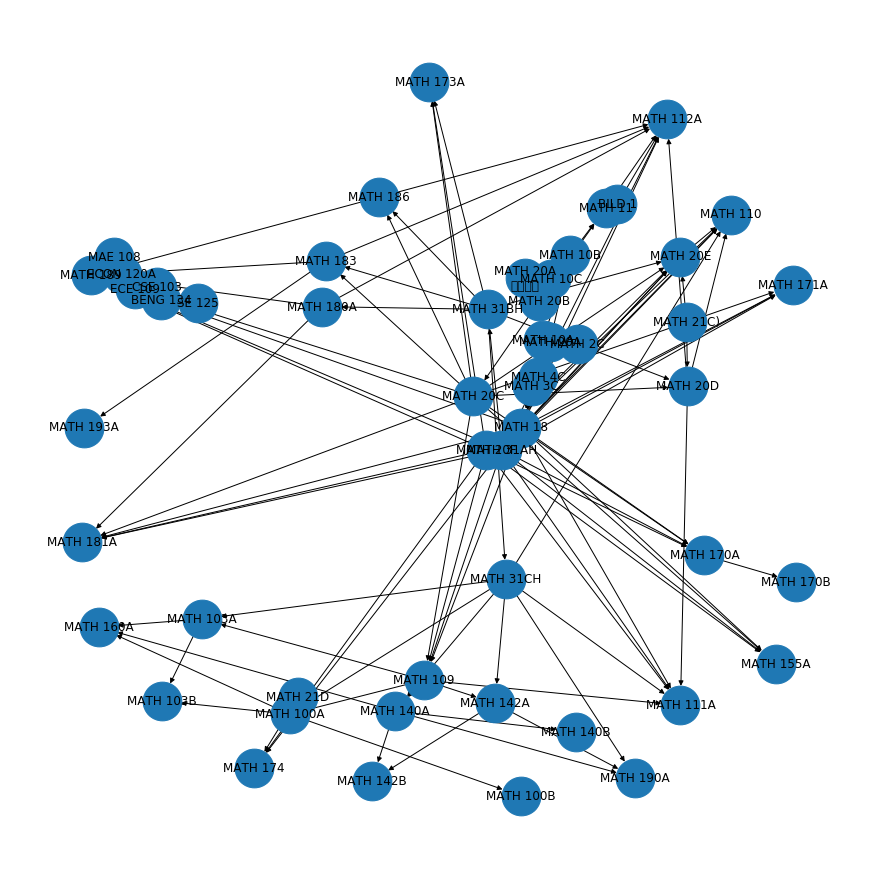

In [9]:
new_edges = []
already_made = []
for key in courses.values():
    for seq in key:
            runner(seq,new_edges,already_made)
            
G = nx.DiGraph()
G.add_edges_from(new_edges)
plt.figure(3,figsize=(12,12))
nx.draw(G, with_labels=True, node_size = 1500)
plt.show()